# DP-CGAN Notebook

## Introduction

This notebook provides the PyTorch implementation of conditional GAN trained in a differentially private setting. This method was firstly introduced in **DP-CGAN : Differentially Private Synthetic Data and Label
Generation** (https://arxiv.org/abs/2001.09700). Originally the model was used for training a differentially-private (DP) generative model on images. However, in this notebook, we look into the application of DP-CGAN on tabular data. The details of this notebook, such as model architecture and preprocessing steps, can be customized further to align with different use cases. 


This notebook will explore the [Kaggle Credit Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) but includes others too. This dataset contains 29 continuous features, with ~285,000 examples/rows and binary labels.

In [1]:
import os
import random
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from opacus import PrivacyEngine
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore", category=UserWarning)

## Differential Privacy

A brief introduction on differential privacy has been provided in the PATE-GAN notebook, which is as follows:


Getting the import logistics out of the way, we'll go into the depths of the PATE-GAN model. The deep math will be deferred back to the paper, and I will try to include only the important bits. 

First things first, an introduction to the idea of **Differential Privacy (DP)**. DP describes the effect on a model's output prediction if a single example is removed from the training dataset. Each specific training example should have very little sway on model behaviour. Intuitively: to maximize privacy, the model should not memorize individual examples, but learn something about the dataset as a whole. 

To quantify DP, models are typically trained to be **(ϵ, δ)-Differentially Private**. Ie. the removal of any one example will affect the models regular output by, at most, exp(ϵ) * output + δ. 

Though this canonical explanation of DP is typically applied to one model, we need our entire GAN model to be differentially-private. However, it can be proven that so long as the discriminator is differentially-private, then the generator is also differentially-private. This result is derived from the post-processing theorem. It states that the composition of some function f with some (ϵ, δ)-DP function g, still results in a (ϵ, δ)-DP function. Intuitively, if you are given some (ϵ, δ)-DP model G, then no amount of clever tinkering can make the model less differentially private. This has a link to information processing, where you cannot create more information then already exists in a vacuum. 

This is all well and great, but what does this mean for application? Can't we just delete columns with names/ids? This may seem attracive, but this is an extremely weak attempt at maintaining privacy of dataset members. The rows of the exposed dataset can be used to search up public records, and in-turn, recover the deleted names/ids. DP denies this kind of attack by minimizing the effect of single members, making linkage attacks untractable. 

We try to give intuitions behind DP, but if you're only convinced by math we have some excellent resources. There's a good write-up on the theory and math behind DP here: https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf.


## Differential Privacy with PyTorch

The same notion of differential privacy described above applies to DP-CGAN. In this notebook, we provide a PyTorch implementation of DP-CGAN where the differential privacy is conducted using the Opacus library (https://opacus.ai/). Opacus adds privacy-related responsibilities to the main PyTorch training objects, i.e., model, optimizer, and the data loader where:
- Model is wrapped to also compute per sample gradients.
- Optimizer is now responsible for gradient clipping and adding noise to the gradients.
- DataLoader is updated to perform Poisson sampling.

All this can be done by 
1. Instantiating the PrivacyEngine

  ```
  privacy_engine = PrivacyEngine()
  ```
  
2. Getting the private counterparts of the training objects while setting the values for the privacy budget, i.e., ϵ and δ. 
  ``` 
  model, optimizer, data_loader = 
  privacy_engine.make_private_with_epsilon(
                          module,
                          optimizer,
                          data_loader,
                          max_grad_norm,
                          target_epsilon,
                          target_delta,
                          epochs
                        )
  ```


## CGAN

Rather than using a vanilla GAN model to generate synthetic data, we employ conditional GAN to be able to have control over the labels of the generated samples. This conditioning can be done by concatenating the label data with the input noise of the Generator. Similarly, the Discriminator takes the concatenation of the data samples and the labels as the input.
Generator and Discriminator in our CGAN architecture include a 2-layer MLP with ReLU nonlinearity. The Generator outputs the generated samples by applying Tanh, while the Discriminator predicts the fakeness of its input by outputting a sigmoid.
Before starting the training, Normal Xavier initialization is applied to the model weights.

In [2]:
class Generator(nn.Module):
    """Conditional GAN generator"""

    def __init__(
        self, latent_dim: int, ngf: int, labels_dim: int, features_dim: int
    ) -> None:
        """
        Args:
            latent_dim (int): The size of the input noise.
            ngf (int): The size of the features is the generator layers.
            label_dim (int): The size of the label vector for each sample.
            features_dim (int): The number of the data features based on the dataset.
        """
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.labels_dim = labels_dim
        self.features_dim = features_dim
        self.ngf = ngf
        self.model = nn.Sequential(
            nn.Linear(self.latent_dim + self.labels_dim, self.ngf),
            nn.ReLU(inplace=True),
            nn.Linear(ngf, features_dim),
            nn.Tanh(),
        )

    def forward(
        self, noise: torch.Tensor, labels: torch.Tensor
    ) -> torch.Tensor:
        if self.labels_dim > 1:
            labels = F.one_hot(labels, num_classes=self.labels_dim)
        else:
            labels = torch.unsqueeze(labels, -1)
        g_input = torch.cat((noise, labels), -1)
        x = self.model(g_input)
        return x


class Discriminator(nn.Module):
    """Conditional GAN discriminator"""

    def __init__(self, ndf: int, features_dim: int, labels_dim: int) -> None:
        """
        Args:
            ndf (int): The size of the features is the discriminator layers.
            features_dim (int): The number of the data features based on the dataset.
            labels_dim (int): The size of the label vector for each sample
        """
        super(Discriminator, self).__init__()
        self.labels_dim = labels_dim
        self.features_dim = features_dim
        self.ndf = ndf
        self.model = nn.Sequential(
            nn.Linear(self.features_dim + self.labels_dim, self.ndf),
            nn.ReLU(inplace=True),
            nn.Linear(ndf, 1),
            nn.Sigmoid(),
        )

    def forward(
        self, input: torch.Tensor, labels: torch.Tensor
    ) -> torch.Tensor:
        if self.labels_dim > 1:
            labels = F.one_hot(labels, num_classes=self.labels_dim)
        else:
            labels = torch.unsqueeze(labels, -1)
        input = input.view(input.size(0), -1)
        d_input = torch.cat((input, labels), -1)
        x = self.model(d_input)
        return x


def init_weights(m: nn.modules) -> None:
    """Initialize weights with Xavier normal initializer

    Args:
        m: Network module
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal(m.weight)
        nn.init.zeros_(m.bias)

## Datasets

In this demo, we consider four tabular datasets with binary labels.
Credit fraud detection
UCI
Cervical cancer
Adult Census
Note that the model performance and the spent privacy budget depend on the datasets.


### Data Loaders

We provide the data loaders for each dataset below. Feel free to add your customized data loader function to run the model using a dataset of your choice.

In [3]:
def load_credit_dataset(dset_dir: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the credit dataset
    Args:
        dset_dir (str): Dataset directory
    Returns:
        A tuple containing the features and labels
    """
    # if not os.path.isdir(dset_dir):
    #     raise Exception("Dataset source file not found")

    dset_path = Path(dset_dir) / "creditcard_fraud_detection.csv"

    df = pd.read_csv(dset_path)
    features = df.copy()

    labels = features.pop("Class")
    features = features.drop(["rownames", "Time"], axis=1)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels


def load_uci_dataset(dset_dir: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the UCI dataset
    Note:
        Amalgamates both test and train splits
    Args:
        dset_dir (str): Dataset directory
    Returns:
        A tuple containing the features and labels
    """
    if not os.path.isdir(dset_dir):
        raise Exception("Dataset source directory not found")

    train_path = Path(dset_dir) / "isolet1+2+3+4.data"
    test_path = Path(dset_dir) / "isolet5.data"

    if not os.path.isfile(train_path):
        raise Exception("Missing UCI training data")

    if not os.path.isfile(test_path):
        raise Exception("Missing UCI test data")

    train_df = pd.read_csv(train_path, header=None)
    test_df = pd.read_csv(test_path, header=None)

    train_features = np.array(train_df.loc[:, :616])
    train_labels = np.array(train_df.loc[:, 617])

    test_features = np.array(test_df.loc[:, :616])
    test_labels = np.array(test_df.loc[:, 617])

    vowels = np.array([1.0, 5.0, 9.0, 15.0, 21.0])

    train_labels = np.isin(train_labels, vowels).astype(np.int32)
    test_labels = np.isin(test_labels, vowels).astype(np.int32)

    features = np.concatenate((train_features, test_features))
    labels = np.concatenate((train_labels, test_labels))

    return features, labels


def load_cervical_cancer_dataset(
    dset_dir: str,
) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the cervical cancer dataset
    Args:
        dset_dir (str): Dataset directory
    Returns:
        A tuple containing the features and labels
    """
    if not os.path.isdir(dset_dir):
        raise Exception("Dataset source directory not found")

    dset_path = Path(dset_dir) / "kag_risk_factors_cervical_cancer.csv"

    dset_df = pd.read_csv(dset_path)
    dset_df = dset_df.replace("?", np.nan)

    # There is an exceedingly large number of NaNs in these two columns
    dset_df = dset_df.drop(
        columns=[
            "STDs: Time since first diagnosis",
            "STDs: Time since last diagnosis",
        ]
    )

    # Drop the remaining NaNs
    dset_df_no_nan = dset_df.dropna()

    labels = np.array(dset_df_no_nan.pop("Biopsy").astype(np.float32))
    features = np.array(dset_df_no_nan.astype(np.float32))

    return features, labels


def load_adult_census_dataset(dset_dir: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the adult census dataset
    Note:
        Amalgamates both test and train splits
    Args:
        dset_dir (str): Dataset directory
    Returns:
        A tuple containing the features and labels
    """
    if not os.path.isdir(dset_dir):
        raise Exception("Dataset source directory not found")

    train_path = Path(dset_dir) / "adult_processed_train.csv"
    test_path = Path(dset_dir) / "adult_processed_test.csv"

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    train_labels = np.array(train_df.pop("income"))
    test_labels = np.array(test_df.pop("income"))

    train_features = np.array(train_df)
    test_features = np.array(test_df)

    features = np.concatenate((train_features, test_features))
    labels = np.concatenate((train_labels, test_labels))

    return features, labels


def get_dataset_loader(
    dset_src: str, dset_name: str
) -> Tuple[np.ndarray, np.ndarray]:
    """Returns the specified dataset loader, according to dset_name
    Args:
        dset_src (str): Dataset source file/directory
    Returns:
        A tuple containing the features and labels
    """
    if dset_name == "credit_fraud":
        return load_credit_dataset(dset_src)
    elif dset_name == "UCI_ISOLET":
        return load_uci_dataset(dset_src)
    elif dset_name == "cervical_cancer":
        return load_cervical_cancer_dataset(dset_src)
    elif dset_name == "adult_census":
        return load_adult_census_dataset(dset_src)
    else:
        raise Exception("Can't find valid dataset loading function")

### Data Splitting

Since the datasets we work with are likely to be unbalanced in terms of the labels, we employ stratified data splitting for train and test sets to retain the same distribution of classes among the labels.


In [4]:
def split_dataset(
    test_ratio: float, dset_name: str, dset_src: str
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Splits the features and labels according to split_ratio

    Args:
        test_ratio (float): The ratio of test samples
        dset_name (str): Dataset name
        dset_src (str): Dataset source file

    Returns:
        A tuple containing the train and test features and labels
    """
    features, labels = get_dataset_loader(dset_src, dset_name)
    train_idx, test_idx = train_test_split(
        np.arange(len(labels)),
        test_size=test_ratio,
        shuffle=True,
        stratify=labels,
    )
    train_features = features[train_idx]
    train_labels = labels[train_idx]
    test_features = features[test_idx]
    test_labels = labels[test_idx]
    return train_features, train_labels, test_features, test_labels

### Class Ratios

When evaluating the model, we need to provide random noise and labels as the input of the Generator. To be attentive to the distribution of data classes in unbalanced datasets, we use the same class ratios for the synthetic dataset labels.

In [5]:
def class_ratios(labels: np.ndarray) -> Tuple[np.ndarray, list]:
    """Computes the class ratios for the synthetic dataset

    Args:
        labels (ndarray): The train set labels

    Returns:
        A tuple containing the list of classes and their ratios
    """
    classes, counts = np.unique(labels, return_counts=True)
    ratios = [counts[i] / len(labels) for i in range(len(classes))]
    return classes, ratios

### Dataset Class

We encapsulate the train and test datasets by a Tabulardataset class which also normalizes the feature values. Further customization and data transformation can be done according to the needs of your dataset.

In [6]:
class TabularDataset(Dataset):
    """Tabular dataset"""

    def __init__(self, features: np.ndarray, labels: np.ndarray) -> None:
        """
        Args:
            dset_name (string): Dataset name
            dset_src (string): Dataset source file
            transform (callable, optional): Optional transform to be applied
        """
        self.features = torch.from_numpy(features)
        self.features = torch.sigmoid(self.features)
        self.labels = torch.from_numpy(labels)

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[idx], self.labels[idx]

    def num_classes(self) -> int:
        return len(torch.unique(self.labels))

    def num_features(self) -> int:
        return len(self.features[0])

    def labels_dim(self) -> int:
        return self.num_classes if self.num_classes() > 2 else 1

## Trainer

The trainer class is in charge of training and evaluating the DP-CGAN model.

1. ``train`` method performs the generator and discriminator training steps by providing the noise and labels as the inputs to the Generator. The Discriminator takes the samples from the training dataset to predict the fakeness of the generated samples. During the training, the spent privacy budget is watched over. Evaluation and checkpointing are done after a pre-determined number of iterations.
 
2. Evaluation is performed in the following order:

    a. Fixed tensors of noise and labels are fed into the Generator so that the model generates the synthetic data samples conditioned on the labels. The size of the generated dataset is determined by the ``synthetic_data_size`` parameter.

    b. To evaluate the Generator's performance, we use the synthetic dataset to train an MLP classifier. The classifier is then tested on the test subset of the real dataset we split before. 
    
    c. We report AUC (Area under the ROC curve) and AP (average precision score) as the evaluation metrics. The higher values of AUC on the real test dataset show a well-trained classifier, which is proof of a good training dataset. A good training dataset here is the synthetic dataset generated by the Generator.

In [7]:
@dataclass
class Trainer:
    """A trainer for CGAN with differential privacy"""

    generator: Generator
    optimizerG: torch.optim
    discriminator: Discriminator
    optimizerD: torch.optim
    criterion: torch.nn.modules.loss
    #privacy_engine: PrivacyEngine
    train_loader: DataLoader
    test_dataset: TabularDataset
    target_epsilon: float
    target_delta: float
    device: str
    epochs: int
    latent_dim: int
    fixed_noise: torch.Tensor
    fixed_labels: np.ndarray
    exp_dir: str
    eval_period: int

    def __post_init__(self):
        self.n_classes = self.test_dataset.num_classes()

    def train(self) -> Tuple[list, list]:
        """Trains the CGAN model with differetial privacy

        Returns:
            A tuple containing list of evaluation metrics: AUC and average precision
        """

        iteration = 0
        best_auc = 0
        budget = True
        mlp_aucs = []
        mlp_aps = []

        for epoch in range(self.epochs):

            if not budget:
                print(
                    "Privacy budget exceeded! Iteration = %d, ε = %.3f"
                    % (iteration, epsilon)
                )
                break

            for _, data in enumerate(self.train_loader):

                real_data = data[0].type(torch.FloatTensor).to(self.device)
                real_labels = data[1].to(self.device)
                batch_size = real_data.size(0)

                label_fake = torch.full(
                    (batch_size, 1), 0.0, device=self.device
                )
                label_true = torch.full(
                    (batch_size, 1), 1.0, device=self.device
                )

                ######################
                # (1) Update D network
                ######################
                self.optimizerD.zero_grad()

                # train with fake data
                noise = torch.randn(
                    batch_size, self.latent_dim, device=self.device
                )
                gen_labels = torch.randint(
                    0, self.n_classes, (batch_size,), device=self.device
                )

                fake = self.generator(noise, gen_labels)

                output = self.discriminator(fake.detach(), gen_labels)
                errD_fake = self.criterion(output, label_fake)
                errD_fake.backward()
                self.optimizerD.step()
                self.optimizerD.zero_grad()

                # train with real data
                output = self.discriminator(real_data, real_labels)
                errD_real = self.criterion(output, label_true)
                errD_real.backward()
                self.optimizerD.step()

                errD = errD_real + errD_fake

                ######################
                # (2) Update G network
                ######################
                self.optimizerG.zero_grad()
                self.optimizerD.zero_grad()

                output_g = self.discriminator(fake, gen_labels)
                errG = self.criterion(output_g, label_true)
                errG.backward()

                self.optimizerG.step()

                #(
                #    epsilon,
                #    best_alpha,
                #) = self.privacy_engine.accountant.get_privacy_spent(
                #    delta=self.target_delta
                #)

                #if epsilon > self.target_epsilon:
                #    budget = False
                #    break

                iteration = iteration + 1
                if iteration % self.eval_period == 0:

                    print(
                        "Iteration = %d, Loss_D = %.2f, Loss_G = %.2f"
                        % (iteration, errD.item(), errG.item())
                    )
                    #print(
                    #    "(ε = %.3f, δ = %.2f) for α = %.2f"
                    #    % (epsilon, self.target_delta, best_alpha)
                    #)
                    mlp_auc, mlp_ap = self._eval()
                    mlp_aucs.append(mlp_auc)
                    mlp_aps.append(mlp_ap)
                    print("mlp_auc = %.3f, mlp_ap = %.3f" % (mlp_auc, mlp_ap))
                    if mlp_auc > best_auc:
                        best_auc = mlp_auc
                        print(
                            f"Checkpoint saved at iteration={iteration}"#", 
                            #eps={epsilon:.3f}"
                        )
                        print(self.discriminator.__dict__)
                        torch.save(
                            {
                                "discriminator": self.discriminator.state_dict(),
                                "generator": self.generator.state_dict(),
                                #"accountant": self.privacy_engine.accountant,
                                "optimizerG": self.optimizerG.state_dict(),
                                "optimmizerD": self.optimizerD.state_dict(),
                            },
                            f"{self.exp_dir}/checkpoint_{iteration}.pth"#_{epsilon:.3f}.pth",
                        )

        return mlp_aucs, mlp_aps

    def _eval(self) -> Tuple[float, float]:
        """Evaluates the model by applying mlp classifier

        Returns:
            A tuple containing the classifier AUC and average precision
        """
        fake_features, fake_labels = self._generate_fake_data()
        mlp = MLPClassifier(early_stopping=True).fit(
            fake_features, fake_labels.flatten()
        )
        class_probs = mlp.predict_proba(self.test_dataset.features)

        auc = metrics.roc_auc_score(
            self.test_dataset.labels,
            class_probs[:, 1],
            average="weighted",
            multi_class="ovo",
        )

        if self.n_classes > 2:
            lb = LabelBinarizer()
            lb.fit(self.test_dataset.labels)
            y_test = lb.transform(self.test_dataset.labels)
        else:
            y_test = self.test_dataset.labels

        ap = metrics.average_precision_score(y_test, class_probs[:, 1])
        return auc, ap

    def _generate_fake_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """generates fake dataset using the DP-CGAN generator

        Returns:
            A tuple of generted features and their corresponding labels
        """
        fixed_labels = torch.from_numpy(self.fixed_labels).to(self.device)
        fake_features = self.generator(self.fixed_noise, fixed_labels).detach()
        fake_features = fake_features.cpu().numpy()
        return fake_features, self.fixed_labels

## Hyperparameters

Below are the arguments and hyperparameters used for training and evaluating DP-CGAN. These values can be changed according to your dataset and the configuration of your choice. 

In [8]:
dset_args = {
    "credit_fraud_src": "/ssd003/projects/aieng/public/SyntheticBootcampDatasets/credit_fraud/",
    "credit_fraud_name": "credit_fraud",
    "credit_fraud_dim": 29,
    "adult_census_file": "/ssd003/projects/aieng/public/SyntheticBootcampDatasets/adult_census",
    "adult_census_name": "adult_census",
    "adult_census_dim": 11,
    "cervical_cancer_file": "/ssd003/projects/aieng/public/SyntheticBootcampDatasets/cervical_cancer",
    "cervical_cancer_name": "cervical_cancer",
    "cervical_cancer_dim": 33,
    "UCI_ISOLET_file": "/ssd003/projects/aieng/public/SyntheticBootcampDatasets/UCI_ISOLET",
    "UCI_ISOLET_name": "UCI_ISOLET",
    "UCI_ISOLET_dim": 617,
}
ARGS = {
    "seed": 42069,
    "secure_rng": False,
    # Enable Secure RNG to have trustworthy privacy guarantees. Comes at a performance cost
    "epsilon": 0.55,
    # Target epsilon
    "max_per_sample_grad_norm": 1.0,
    # Clip per-sample gradients to this norm
    "delta": 1e-5,
    # Target delta
    "latent_dim": 100,
    # Size of the latent z vector
    "ngf": 128,
    # Number of features in the generator layers
    "ndf": 128,
    # Number of features in the discriminator layers
    "epochs": 5,
    # Number of epochs to spend the privacy budget for
    "lr": 0.0002,
    # Learning rate
    "beta1": 0.5,
    # Beta1 for adam
    "beta2": 0.999,
    # Beta2 for adam
    "eval_period": 100,
    # Evaluation and checkpointing interval
    "dset_src": dset_args["credit_fraud_src"],
    # Dataset directory
    "dset_name": dset_args["credit_fraud_name"],
    # Dataset name
    "workers": 2,
    # Number of data loading workers
    "batch_size": 128,
    # Training batch size
    "split_ratio": 0.2,
    # Test ratio for splitting the dataset
    "synth_data_size": 250000,
    # Size of synthetic dataset for evaluation
    "checkpoint": "",
    # Path to checkpoint file
    "exp_dir": "./default_exp"
    # Experiment directory
}

## Main

``main`` script instantiates the modules and privacy engine, calls the ``train`` method, and terminates by saving the evaluation results.

In [9]:
def main():

    os.makedirs(ARGS["exp_dir"], exist_ok=True)

    torch.manual_seed(ARGS["seed"])
    rng = np.random.default_rng(ARGS["seed"])

    device = "cuda" if torch.cuda.is_available() else "cpu"

    (train_features, train_labels, test_features, test_labels) = split_dataset(
        ARGS["split_ratio"],
        ARGS["dset_name"],
        ARGS["dset_src"],
    )

    train_dataset = TabularDataset(train_features, train_labels)
    test_dataset = TabularDataset(test_features, test_labels)

    features_dim = train_dataset.num_features()
    labels_dim = train_dataset.labels_dim()

    train_loader = DataLoader(
        train_dataset,
        num_workers=ARGS["workers"],
        batch_size=ARGS["batch_size"],
        shuffle=True,
    )

    generator = Generator(
        latent_dim=ARGS["latent_dim"],
        ngf=ARGS["ngf"],
        features_dim=features_dim,
        labels_dim=labels_dim,
    )
    generator = generator.to(device)
    generator.apply(init_weights)

    optimizerG = optim.Adam(
        generator.parameters(),
        lr=ARGS["lr"],
        betas=(ARGS["beta1"], ARGS["beta2"]),
    )

    discriminator = Discriminator(
        ndf=ARGS["ndf"], features_dim=features_dim, labels_dim=labels_dim
    )
    discriminator = discriminator.to(device)
    discriminator.apply(init_weights)

    optimizerD = optim.Adam(
        discriminator.parameters(),
        lr=ARGS["lr"],
        betas=(ARGS["beta1"], ARGS["beta2"]),
    )

    #privacy_engine = PrivacyEngine(secure_mode=ARGS["secure_rng"])

    if ARGS["checkpoint"] != "":
        checkpoint = torch.load(ARGS["checkpoint"])
        generator.load_state_dict(checkpoint["generator"])
        discriminator.load_state_dict(checkpoint["discriminator"])
        optimizerG.load_state_dict(checkpoint["optimizerG"])
        optimizerD.load_state_dict(checkpoint["optimmizerD"])
        #privacy_engine.accountant = checkpoint["accountant"]

        print(f'checkpoint loaded from {ARGS["checkpoint"]}')

    # Opacus adds privacy-related responsibilites to the main PyTorch training objects:
    # model, optimizer, and the data loader.
    #(
    #    discriminator,
    #    optimizerD,
    #    train_loader,
    #) = privacy_engine.make_private_with_epsilon(
    #    module=discriminator,
    #    optimizer=optimizerD,
    #    data_loader=train_loader,
    #    max_grad_norm=ARGS["max_per_sample_grad_norm"],
    #    target_epsilon=ARGS["epsilon"],
    #    target_delta=ARGS["delta"],
    #    epochs=ARGS["epochs"],
    #)

    criterion = nn.BCELoss()

    fakedata_size = min(train_dataset.__len__(), ARGS["synth_data_size"])
    fixed_noise = torch.randn(fakedata_size, ARGS["latent_dim"], device=device)
    classes, ratios = class_ratios(train_labels)
    fixed_labels = rng.choice(classes, size=fakedata_size, p=ratios)

    trainer = Trainer(
        generator=generator,
        optimizerG=optimizerG,
        discriminator=discriminator,
        optimizerD=optimizerD,
        criterion=criterion,
        #privacy_engine=privacy_engine,
        train_loader=train_loader,
        test_dataset=test_dataset,
        target_epsilon=ARGS["epsilon"],
        target_delta=ARGS["delta"],
        device=device,
        epochs=ARGS["epochs"],
        latent_dim=ARGS["latent_dim"],
        fixed_noise=fixed_noise,
        fixed_labels=fixed_labels,
        exp_dir=ARGS["exp_dir"],
        eval_period=ARGS["eval_period"],
    )

    mlp_aucs, mlp_aps = trainer.train()

    iters = np.arange(
        ARGS["eval_period"],
        (len(mlp_aucs) + 1) * ARGS["eval_period"],
        ARGS["eval_period"],
    )
    df = pd.DataFrame(
        {
            "iter": iters,
            "mlp_auc": np.array(mlp_aucs),
            "mlp_ap": np.array(mlp_aps),
        }
    )
    df.plot(
        x="iter",
        y=["mlp_auc", "mlp_ap"],
        kind="line",
        xticks=iters // ARGS["eval_period"],
        xlabel=f'iters/{ARGS["eval_period"]}',
    )
    plt.savefig(f'{ARGS["exp_dir"]}/mlp_auc.png')
    df.to_csv(f'{ARGS["exp_dir"]}/mlp_metrics.csv')

Iteration = 100, Loss_D = 1.12, Loss_G = 0.59
mlp_auc = 0.854, mlp_ap = 0.119
Checkpoint saved at iteration=100
{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': OrderedDict([('model', Sequential(
  (0): Linear(in_features=30, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=1, bias=True)
  (3): Sigmoid()
))]), 'labels_dim': 1, 'features_dim': 29, 'ndf': 128}
Iteration = 200, Loss_D = 1.27, Loss_G = 0.79
mlp_auc = 0.908, mlp_ap = 0.460
Checkpoint saved at iteration=200
{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_f

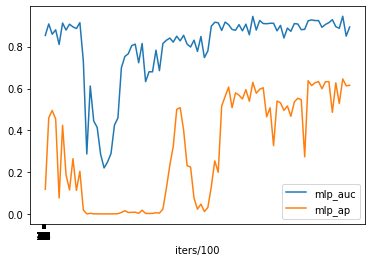

In [10]:
main()